In [68]:
%pip install xgboost
%conda install seaborn

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Note: you may need to restart the kernel to use updated packages.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.10.26 |       h06a4308_2         115 KB
    certifi-2021.10.8          |   py37h06a4308_0         151 KB
    conda-4.11.0               |   py37h06a4308_0        14.4 MB
    seaborn-0.11.2             |     pyhd3eb1b0_0         218 K

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

from sklearn.metrics import f1_score, plot_precision_recall_curve, plot_roc_curve, plot_confusion_matrix

import sys; sys.path.insert(0, '..') # add parent folder path where discrepancies folder is

from discrepancies import datasets, pool, discrepancies_intervals, DIG

RANDOM_STATE = 42

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

In [2]:
X_train, X_test, y_train, y_test, scaler, feature_names, target_names, cat_names = datasets.get_dataset(dataset='half-moons',
                n_samples=1000,
                test_size=0.33,
                standardize=True,
                noise=0.3)

[12:51:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracies (F1):  {'SVMrbf': 0.8917197452229298, 'RF200': 0.9171974522292994, 'XGB': 0.9009584664536742, 'LR': 0.8500000000000001, 'GB': 0.8987341772151898}
Discrepancies on train: 0.15970149253731344
Discrepancies on test: 0.18181818181818182


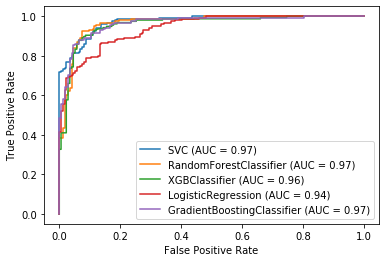

In [3]:
pool1 = pool.BasicPool(models=["SVMrbf", "RF200", "LR", "XGB", "GB"])
pool1 = pool1.fit(X_train.values, y_train)

preds = pool1.predict(X_test)

print("Accuracies (F1): ", {c: f1_score(y_test, preds[c]) for c in preds.columns})
print("Discrepancies on train:", pool1.predict_discrepancies(X_train).mean())
print("Discrepancies on test:", pool1.predict_discrepancies(X_test).mean())

classifiers = [v for k, v in pool1.models.items()]#[pool1.models["SVMrbf"], pool1.models["RF200"]]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax)

In [4]:
def normalize(x):
    return ((x-X_test.min())/(X_test.max()-X_test.min()))

def get_discrepancy_intervals_from_x(G, x, k=10):

    # Get all discrepancy intervals from the graph
    intervals = discrepancies_intervals.get_discrepancies_intervals(G)

    # Compute distances between x and every discrepancy interval
    dists = []
    for di in intervals:
        dists.append( di.get_min_dist_to_point(x) )

    # Retrieve borders of the k closest intervals - and the points from the train at the origin of the intervals
    borders, train = {}, {}
    i = 0
    for di in np.array(intervals)[np.argsort(dists)][:k]:
        df = di.border_features
        df = pd.DataFrame(df)
        borders[i] = df 

        df = [G.nodes(data=True)[di.X_train_nodes[i]]['features'] for i in [0,1]]
        df = pd.DataFrame(df)
        train[i] = df
        i += 1

    return borders, train

In [5]:
%%time 
dig = DIG.Digger(X_train, y_train, pool1, k_init=10, categorical_names=cat_names)

dig.fit(max_epochs=5)
intervals = discrepancies_intervals.get_discrepancies_intervals(dig.G)

print(len(intervals))

INFO:root:### EPOCH #1
INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5


7819
CPU times: user 23.2 s, sys: 507 ms, total: 23.7 s
Wall time: 23.8 s


In [31]:
x = X_train.iloc[0]
k = 10

borders, train = get_discrepancy_intervals_from_x(dig.G, x, k=k)

fi = {}
for interval in range(k):
    fi[interval] = borders[interval].iloc[1,:]
    fi[-(k+1)] = borders[interval].iloc[0,:]
fi = pd.DataFrame(fi).T

<Figure size 640x480 with 0 Axes>

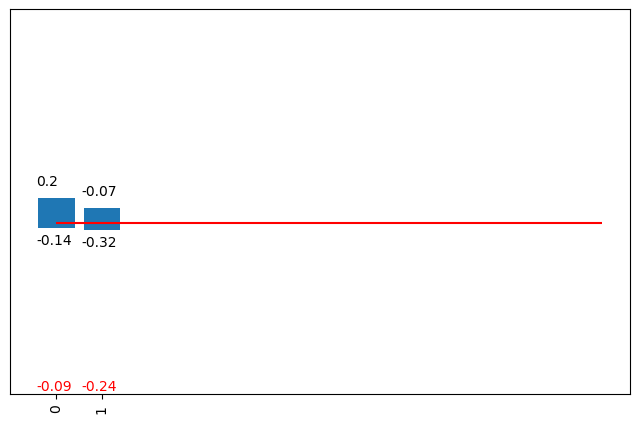

In [15]:
mpl.style.use('default')
plt.viridis()

fig, ax = plt.subplots(figsize=(8,5))
plt.bar(x=range(len(x)), height=normalize(fi.max())-normalize(fi.min()), bottom=normalize(fi.min())-normalize(x))

plt.hlines(0, 0, 12, color='r')

for i in range(len(x)):
    y1 = normalize(fi.max()).iloc[i] - normalize(x).iloc[i]
    ax.text(i-0.45, y1+0.03, str(fi.max().round(2).iloc[i]))

for i in range(len(x)):
    y2 = normalize(fi.min()).iloc[i] - normalize(x).iloc[i]
    ax.text(i-0.45, y2-0.04, str(fi.min().round(2).iloc[i]))

for i in range(len(x)):
    y2 = -0.35
    ax.text(i-0.45, y2-0.04, str(x.round(2).iloc[i]), c='r')

gar = ax.set_ylim((-0.4,0.5))
gar = ax.set(yticklabels=[])
gar = ax.tick_params(left=False)
gar = plt.xticks(np.arange(len(x)), list(x.index), rotation=90)

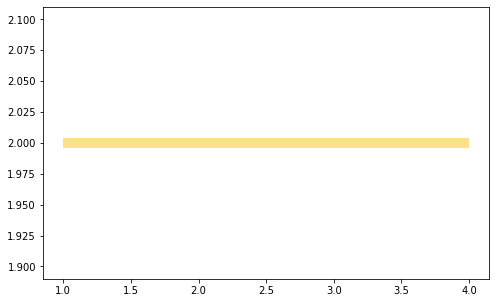

In [71]:
alphas = [     0.01,  0.05,   0.1] 
widths = [ '99% CI', '95%', '90%']
colors = ['#fee08b','#fc8d59','#d53e4f']

fig, ax = plt.subplots(figsize=(8,5))

y = [2]
xmin = [1]
xmax = [4]

plt.hlines(y=y, xmin=xmin, xmax=xmax, colors=colors[0], label=widths[0], linewidth=10) 

In [56]:
tmp = X_train.melt()
print(tmp.head())

  variable     value
0        0 -0.088472
1        0 -0.521629
2        0 -0.249882
3        0 -0.778465
4        0 -0.716224


In [63]:
fi.max()

0    0.197592
1   -0.071948
dtype: float64

In [109]:
y_discr = dig.pool.predict_discrepancies(X_train)
tmp = pd.concat((X_train,y_discr), axis=1)
tmp

,0,1,0
0,-0.088472,-0.242355,0
1,-0.521629,-0.350582,0
2,-0.249882,-0.700834,0
3,-0.778465,0.206917,1
4,-0.716224,0.640097,1
...,...,...,...
665,-0.582426,0.018725,1
666,-1.654626,-0.839733,0
667,-1.552080,0.269331,0
668,0.793306,0.043463,1


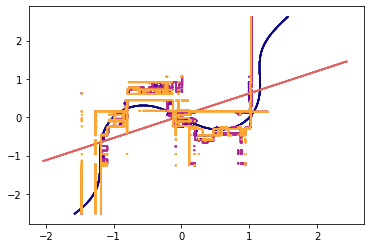

In [129]:
alphas = [     0.01,  0.05,   0.1] 
widths = [ '99% CI', '95%', '90%']
colors = ['#d53e4f','#fee08b','#fc8d59']

def plot_intervals(x, X, y_discr):
    
    
    y_discr.name = 'discrepancies'
    X_melted = pd.concat((X, y_discr), axis=1)
    X_melted = X_melted.melt(id_vars=['discrepancies'])
    
    fig, axs = plt.subplots(nrows=X.shape[1])
    
    for i in range(X.shape[1]):
        
        # //!!\\ pay attention if data normalization is consistent
        
        plt.axes(axs[i])
        plt.ylabel('variable = '+str(X.columns[i]))
        
        # if data numerical
        data = X_melted[X_melted.variable==X.columns[i]]

        sns.rugplot(data=data, x="value", height=.1, hue='discrepancies')
        
        fib = fi.iloc[:,i]
        plt.hlines(y=[0.1], xmin=[fib.min()], xmax=[fib.max()], linewidth=5, colors=colors[0], label=widths[0])
        
        plt.vlines(x.iloc[i], 0, 0.2, color='r')
        
#        for j in range(100):
#            fic = intervals[j].border_features.iloc[:,i]
#            plt.hlines(y=[0.2], xmin=[fic.min()], xmax=[fic.max()], linewidth=5, colors=colors[1], label=widths[0])
        
        # if data categorical


x = X_train.iloc[np.random.choice(X_train.index)]
y_discr = dig.pool.predict_discrepancies(X_train)

plot_intervals(x, X_train, y_discr)


dig.plot_db()